# --------------------------------------------------------------
# Code for van der Pol Oscillator example: MS-DeepONet architecture
# --------------------------------------------------------------
## This notebook includes:
 - Input signal generation
 - Simulation of van der Pol Dynamics and data generation for training 
 - MS-DeepONet prediction model learning using pytorch
 - Model Predictive Control (MPC) simulation
# --------------------------------------------------------------

### Import required packages

In [27]:
# Standard libraries
import time
import itertools

# Scientific computing
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.io import savemat

# Plotting
import matplotlib.pyplot as plt

# Deep learning
import torch
import torch.nn.functional as F
import models  # your custom model module

# Optimization (solving the MPC problem)
import casadi as ca

# Functions used in scripts
from functions import van_der_pol, NN, multisine
 

### Generate input signal used for model learning

(2410,)
(2410,)


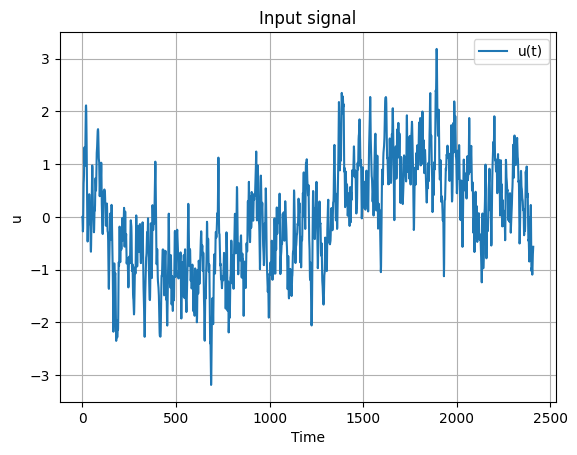

In [28]:
# Generate multisine
u_data = 2*multisine(N_points_per_period=2410, N_periods=1, pmin=1, pmax=500, n_crest_factor_optim=100,seed=42)

# Generate a single sine 
x = np.linspace(-np.pi, np.pi, 2410)

# Add the multisine to the single sine wave
u_data = u_data + np.sin(x)

# Filter the input signal trough a low pass filter
print(u_data.shape)
u_filtered = np.zeros(len(u_data))
print(u_filtered.shape)
for i in range(0,len(u_data)-1):
    # print(i)
    u_filtered[i+1] = 0.9*u_filtered[i] + 0.1*u_data[i]


# Plot the final input signal which will be used to generate the data
plt.plot(u_filtered, label='u(t)')
plt.title('Input signal')
plt.xlabel('Time')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.show()

### Generate output data for the van der Pol Oscillator, used for training

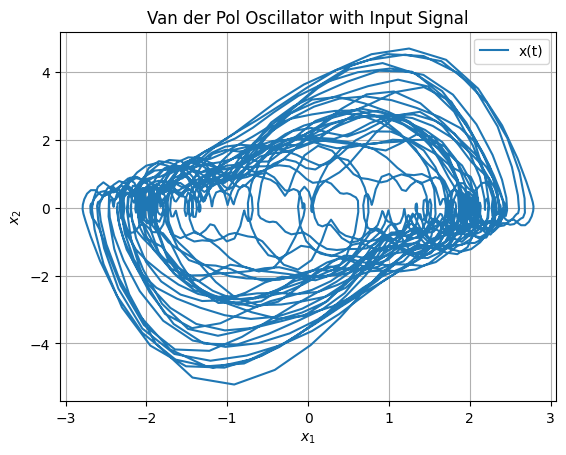

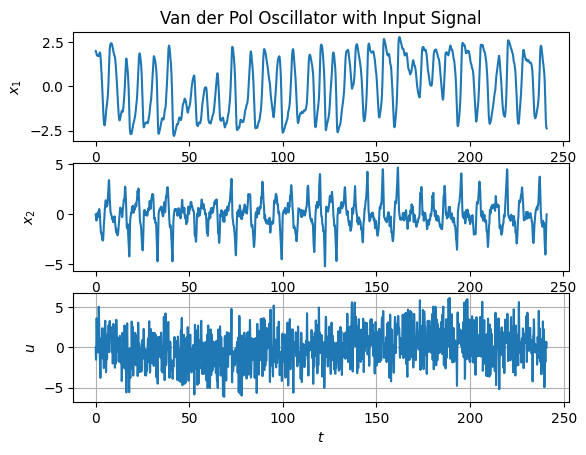

In [29]:
# Parameters
N = 10 # prediction horizon of the controller
Ts = 0.1 # Sampling time of the controller
mu = 1.0  # You can change this value to see different behaviors
y0 = [2, 0]  # Initial conditions: [x0, dx0]
t_total = 2410 * Ts  # total simulation time
time_steps = 2410

t_span = (0, 20)  # Time interval
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points to evaluate
t_vec = [0]
x = [y0]

# Main loop
for i in range(len(u_data)):
    u = u_data[i]
    sol = solve_ivp(lambda t, y: van_der_pol(t, y, mu, u),[0, Ts], y0, method='RK45')

    # Take the last value as the new initial condition
    y0 = sol.y[:, -1]
    x.append(y0)  # store state
    t_vec.append((i+1) * Ts)  # store time

# Convert list to numpy array for easier plotting
x = np.array(x)
t_vec = np.array(t_vec)

# Plotting
plt.plot(x[:, 0], x[:, 1], label='x(t)')
plt.title('Van der Pol Oscillator with Input Signal')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()

# Plotting
plt.subplot(3,1,1)
plt.plot(t_vec, x[:, 0], label='$x_1$')
plt.title('Van der Pol Oscillator with Input Signal')
plt.ylabel('$x_1$')
plt.xlabel('$t$')
plt.subplot(3,1,2)
plt.plot(t_vec, x[:, 1], label='$x_2$')
plt.ylabel('$x_2$')
plt.xlabel('$t$')
plt.subplot(3,1,3)
plt.plot(t_vec[:-1], u_data, label='$x_2$')
plt.ylabel('$u$')
plt.xlabel('$t$')
plt.grid()
plt.show()



### Generate Hankel matrices used for model learning

In [30]:
# Initialze empty data matrices
U = [] # Input data matrix
X0 = [] # Initial condition data matrix
Y = [] # Output data matrix
T = len(u_data) # Length of the input signal 

# For loop for generating Hankel matrices
for i in range(T - N):
    # Input sequence of length N
    U.append(u_data[i:i+N])  #  Append Y with output data
    Y_i = [] # Initialize intermediate output data matrix
    for j in range(N): # Generate length N output vector
        Y_i.append(x[i + j + 1,0])  
    Y.append(Y_i)  # Append Y with length N output vector
    X0.append(x[i,:])  # Append X0 with initial conditions

# Convert to numpy arrays 
U = np.array(U)      
X0 = np.array(X0)    
Y = np.array(Y)      

# Divide Data sets into training and validation 
U_train = U[0:2000,:]
U_test = U[2000:,:]
X0_train = X0[0:2000,:]
X0_test = X0[2000:,:]
Y_train = Y[0:2000,:]
Y_test = Y[2000:,:]

# Optional: print shapes
print("Shapes after split:")
print(f"U_train: {U_train.shape}, U_test: {U_test.shape}")
print(f"X0_train: {X0_train.shape}, X0_test: {X0_test.shape}")
print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")



Shapes after split:
U_train: (2000, 10), U_test: (400, 10)
X0_train: (2000, 2), X0_test: (400, 2)
Y_train: (2000, 10), Y_test: (400, 10)


### Train the MS-DeepONet model 

In [32]:
# Define the network dimensions
ld_list = [20] # Neurons in output layer, change to [20,30,...] to train for multiple combinations
neuron_list = [40] # Neurons per hidden layer, change to [20,30,...] to train for multiple combinations
layer_list = [3] # number of hidden layers, change to [2,3,...] to train for multiple combinations
N_epoch = 400 # Number of epochs used for training the model
N_comb = len(ld_list)*len(neuron_list)*len(layer_list) # Total number of hyperparameter configurations to train for

device = torch.device("cpu:0") # Place tensors on CPU

# Convert training data to tensors
trunk_input_train = torch.tensor(X0_train, dtype=torch.float32).to(device)
branch_input_train = torch.tensor(U_train, dtype=torch.float32).to(device)
output_train = torch.squeeze(torch.tensor(Y_train, dtype=torch.float32).to(device))

# Convert validation data to tensors
trunk_input_val = torch.tensor(X0_test, dtype=torch.float32).to(device)
branch_input_val = torch.tensor(U_test, dtype=torch.float32).to(device)
output_val = torch.squeeze(torch.tensor(Y_test, dtype=torch.float32).to(device))

# Network and data dimensions
B_train = len(trunk_input_train[:,0]) # Batch size for training data
B_val = len(trunk_input_val[:,0]) # Batch size for validation data
nx = len(trunk_input_train[0,:]) # Input dimension Trunk net
Nnu = len(branch_input_train[0,:]) # Input dimension Branch net
Nny = len(output_train[0,:]) # Output dimension network

# Define the network using pytorch 
def train(idx,neuron,layer,ld,loss_val_i,niter):
    # Define the Branch network:
    branch = models.MLP(
        layers=[Nnu] + [neuron] * layer + [ld*Nny],
        activation=F.tanh,
    ).to(device)

    # Define the Trunk network:
    trunk = models.MLP(layers=[nx] + [neuron] * layer + [ld], activation=F.tanh).to(device)

    # Define the optimizer, learning rate, weight decay
    optimizer = torch.optim.AdamW(
        list(branch.parameters()) + list(trunk.parameters()), 
        lr=1e-3, # Learning rate
        weight_decay=1e-4  # L2 regularization (weight decay)
    )

    # Add a learning rate scheduler that reduces the learning rate by a factor of gamma every step_size iterations
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

    # Initialize empty list for storing the training and validation loss
    train_loss_hist = []
    val_loss_hist = []
    t0 = time.time()
    # training loop
    for i in range(niter):
        # Training step
        def train_step():
            optimizer.zero_grad() # reset the gradients    
            # Forward pass:     
            b_out = branch(branch_input_train) # Branch net forward pass
            t_out = trunk(trunk_input_train) # Trunk net forward pass
            b_out = b_out.reshape(B_train, Nny, ld) # convert Branch net output layer into matrix
            u_pred = torch.einsum("bij,bj->bi", b_out, t_out) # Product layer
            loss = torch.mean((u_pred - output_train) ** 2) / torch.mean((output_train) ** 2) # Calculate training loss 
            loss.backward() # Backward pass
            optimizer.step() # Update parameters
            return loss
        
        # Validation step
        def validation_step():
             with torch.no_grad():               
                b_out = branch(branch_input_val)
                t_out = trunk(trunk_input_val)
                b_out = b_out.reshape(B_val, Nny, ld)
                u_pred = torch.einsum("bij,bj->bi", b_out, t_out)
                loss = torch.mean((u_pred - output_val) ** 2) / torch.mean((output_val) ** 2)
                return loss

        loss_train = train_step() # Perform a training step (includes forward pass, loss calc, backward pass, optimizer step)
        loss_val = validation_step() # Perform a validation step (forward pass + loss calc, no weight updates)
        l_train = loss_train.detach().cpu().numpy() # Move training loss tensor to CPU, detach from graph, convert to NumPy
        l_val = loss_val.detach().cpu().numpy() # Same as above for validation loss

        train_loss_hist.append(l_train) # Append training loss data 
        val_loss_hist.append(l_val) # Append validation loss data 

        current_lr = optimizer.param_groups[0]['lr'] # Get the current learning rate from the optimizer
        current_lr = round(current_lr, 5) # Round the learning rate to 5 decimal places for printing
        
        # Print usefull information during training:
        if i % 10 == 0:
            print(
                "index: ",
                idx,
                "/ ",
                N_comb,
                " Epoch: ",
                i + 1,
                "Learning rate: ",
                current_lr,
                "Train loss",
                l_train,
                "Val loss",
                l_val,
                flush=True,
            )
        # Save the model every 100 iterations and only when validation loss has decreased
        if i % 100 == 0 and loss_val_i >= l_val:
            loss_val_i = l_val
            l_indx_i = i
            torch.save(branch, "data_MS/kan_mlp_branch_idx_{}".format(str(int(idx))))
            torch.save(trunk, "data_MS/kan_mlp_trunk_idx_{}".format(str(int(idx))))

        # Step the learning rate scheduler at the end of each iteration
        scheduler.step()
        
    t1 = time.time()
    print("Total time: ", t1 - t0, flush=True)
    # Save training and validation losses
    np.save("data_MS/train_loss.npy", train_loss_hist, allow_pickle=True)
    np.save("data_MS/val_loss.npy", val_loss_hist, allow_pickle=True)

    return np.array(train_loss_hist), np.array(val_loss_hist), l_indx_i, loss_val_i


# start of the ablation study 
ablation_results = [] # Initialize empty list for storing the ablation results 
combinations = itertools.product(ld_list,neuron_list,layer_list) # Generate set of hyperparameter configurations for ablation study 
idx_i = 0 # Initialize training index 

# Looping through the range of indices (1 to idx_total-1 in this case, but you can extend it)
for ld_i, neuron_i, layer_i in combinations:
    idx_i += 1
    # Call the train function with the current index
    train_loss_hist_i, val_loss_hist_i, l_indx_opt, loss_val_opt   = train(idx=idx_i,ld=ld_i,neuron=neuron_i,layer=layer_i,loss_val_i=float('inf'),niter=N_epoch)
    
    # Create a dictionary to store the ablation results
    results = {
        'idx': idx_i,
        'neurons output layer': ld_i,
        'neurons hidden per layer': neuron_i,
        'hidden layers': layer_i,
        'training loss': train_loss_hist_i,
        'validation loss': val_loss_hist_i
    }
    
    # Append the results to the ablation_results list
    ablation_results.append(results)


index:  1 /  1  Epoch:  1 Learning rate:  0.001 Train loss 0.98568594 Val loss 0.9599715
index:  1 /  1  Epoch:  11 Learning rate:  0.001 Train loss 0.6700505 Val loss 0.6541798
index:  1 /  1  Epoch:  21 Learning rate:  0.001 Train loss 0.19892997 Val loss 0.24086072
index:  1 /  1  Epoch:  31 Learning rate:  0.001 Train loss 0.07694274 Val loss 0.08700542
index:  1 /  1  Epoch:  41 Learning rate:  0.001 Train loss 0.05825681 Val loss 0.06813402
index:  1 /  1  Epoch:  51 Learning rate:  0.001 Train loss 0.038301416 Val loss 0.045644633
index:  1 /  1  Epoch:  61 Learning rate:  0.001 Train loss 0.031171512 Val loss 0.03807077
index:  1 /  1  Epoch:  71 Learning rate:  0.001 Train loss 0.028051127 Val loss 0.034200523
index:  1 /  1  Epoch:  81 Learning rate:  0.001 Train loss 0.025206096 Val loss 0.03186738
index:  1 /  1  Epoch:  91 Learning rate:  0.001 Train loss 0.023343429 Val loss 0.030716293
index:  1 /  1  Epoch:  101 Learning rate:  0.001 Train loss 0.021666832 Val loss 0.02

### Plot the training and validation loss

Text(0.5, 1.0, 'Training and validation loss')

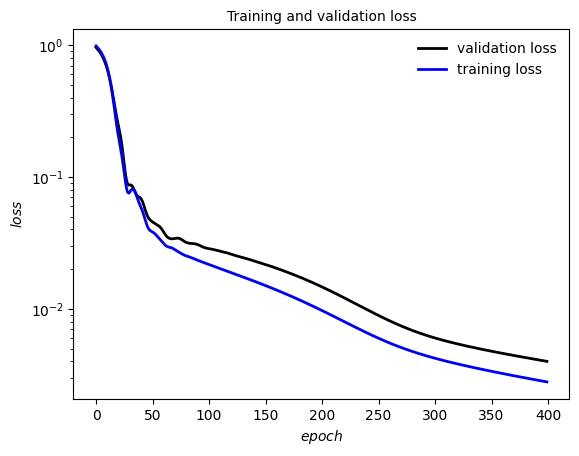

In [33]:
# Load the loss data
val_loss = np.load("data_MS/val_loss.npy")
train_loss = np.load("data_MS/train_loss.npy")

####### Row 0: u(t,x) ##################    
plt.semilogy(val_loss, '-k', lw=2.0, label="validation loss")
plt.semilogy(train_loss, '-b', lw=2.0, label="training loss")
plt.xlabel('$epoch$')
plt.ylabel('$loss$')
plt.legend(frameon=False, loc = 'best')
plt.title('Training and validation loss', fontsize = 10)

### Perform MS-DeepONet based MPC simulation

i = 0 / 390
i = 1 / 390
i = 2 / 390
i = 3 / 390
i = 4 / 390
i = 5 / 390
i = 6 / 390
i = 7 / 390
i = 8 / 390
i = 9 / 390
i = 10 / 390
i = 11 / 390
i = 12 / 390
i = 13 / 390
i = 14 / 390
i = 15 / 390
i = 16 / 390
i = 17 / 390
i = 18 / 390
i = 19 / 390
i = 20 / 390
i = 21 / 390
i = 22 / 390
i = 23 / 390
i = 24 / 390
i = 25 / 390
i = 26 / 390
i = 27 / 390
i = 28 / 390
i = 29 / 390
i = 30 / 390
i = 31 / 390
i = 32 / 390
i = 33 / 390
i = 34 / 390
i = 35 / 390
i = 36 / 390
i = 37 / 390
i = 38 / 390
i = 39 / 390
i = 40 / 390
i = 41 / 390
i = 42 / 390
i = 43 / 390
i = 44 / 390
i = 45 / 390
i = 46 / 390
i = 47 / 390
i = 48 / 390
i = 49 / 390
i = 50 / 390
i = 51 / 390
i = 52 / 390
i = 53 / 390
i = 54 / 390
i = 55 / 390
i = 56 / 390
i = 57 / 390
i = 58 / 390
i = 59 / 390
i = 60 / 390
i = 61 / 390
i = 62 / 390
i = 63 / 390
i = 64 / 390
i = 65 / 390
i = 66 / 390
i = 67 / 390
i = 68 / 390
i = 69 / 390
i = 70 / 390
i = 71 / 390
i = 72 / 390
i = 73 / 390
i = 74 / 390
i = 75 / 390
i = 76 / 390
i = 77 / 

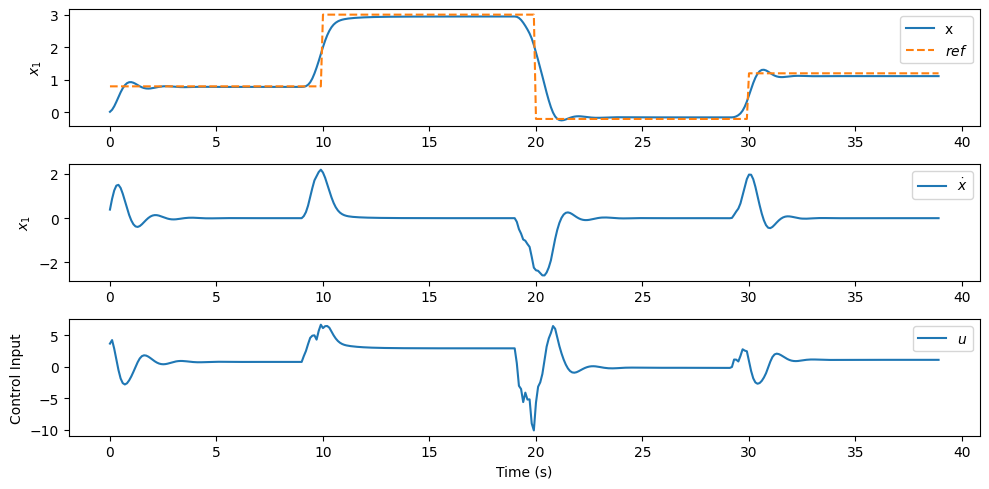

In [34]:
# select optimal index based on the minimal validation loss in ablation_results:
idx_opt = 1 # 
branch = torch.load("data_MS/kan_mlp_branch_idx_{}".format(str(int(idx_opt))), weights_only=False)
trunk = torch.load("data_MS/kan_mlp_trunk_idx_{}".format(str(int(idx_opt))), weights_only=False)

# Van der Pol Oscillator parameters
mu = 1 # mu parameter for van der pol oscillator 
ld_list = 20 # Select here correct number of neurons in output layer of model with index idx_opt
N = 10  # Select here correct prediction horizon of model with index idx_opt

# System dimensions van der
nx = 2  # [theta, theta_dot]
ny = 1  # [theta, theta_dot]
nu = 1  # torque

# MPC cost function matrices
Q = np.eye(N) * 100
R = np.eye(N * nu)



# Define constant pieces
ref1 = np.tile([0.8], (100, 1))     # Shape (30, 2)
ref2 = np.tile([3.0], (100, 1))    # Shape (40, 2)
ref3 = np.tile([-0.2], (100, 1))     # Shape (30, 2)
ref4 = np.tile([1.2], (100, 1))     # Shape (30, 2)

# Concatenate them along the first axis (time steps)
xref_traj = np.concatenate((ref1, ref2, ref3,ref4), axis=0)  # Shape (100, 2)

# Set up optimization problem
opti = ca.Opti()
y = opti.variable(ny*N,)
u = opti.variable(nu*N,)
du = opti.variable(nu*N,)
x0 = opti.parameter(nx)
u0 = opti.parameter(nu)
ref = opti.parameter(ny*N,)

# Define cost function
cost = ca.mtimes([(y-ref).T, Q, (y-ref)]) + ca.mtimes([du.T, R, du])

# Neural network predictions
b_out = NN(u, branch, np.tanh)
t_out = NN(x0, trunk, np.tanh)
b_out = ca.reshape(b_out, ld_list, N)
    
# Define constrains for the MPC problem
opti.subject_to(y == b_out.T@t_out) # Prediction model 
opti.subject_to(du[0:nu] == u[0:nu] - u0) # Define \delta u(0)
opti.subject_to(du[nu:] == u[nu:] - u[:-nu]) # Define  \delta u

# Define optimization problem
opti.minimize(cost)

# Solver options 
opti.solver('ipopt', {'ipopt.print_level': 0, 'print_time': 0})


x_vals = [] # Initialize empty list for storing state data
u_vals = [] # Initialize empty list for storing input data
solve_times = []  # Initialize empty list to store time per control action 

x_current = np.array([0.0, 0.0])  # Initial conditions for van de Pol oscillator
u_mpc = 0 # Initial condition for inut (needed for \delta u(0))

for i in range(len(xref_traj)-N):
    print(f'i = {i} / {len(xref_traj)-N}') # Print progress simulation 
    REF = xref_traj[i:i+N,:].T # Define current reference signal 

    opti.set_value(x0, x_current) # Set initial condition
    opti.set_value(u0, u_mpc) # set initial input 
    opti.set_value(ref, REF) # set reference signal 

    start = time.perf_counter() # initialize counter
    sol = opti.solve() # solve MPC problem
    elapsed = time.perf_counter() - start # store required time for solving MPC problem
    solve_times.append(elapsed)  # Store each solve time 

    u_mpc = sol.value(u[0]) # Exctract current output, to be applied to the system 
    
    # Apply input to van der pol oscillator and simulate for Ts seconds
    sol = solve_ivp(lambda t, y: van_der_pol(t, y, mu, u_mpc),[0, Ts], x_current, method='RK45')

    # Take the last value as the new initial condition
    x_next = sol.y[:, -1] # measured state at t = (i+1)T_s
    x_vals.append(x_next) # Append state data vector
    u_vals.append(u_mpc) # Append input data vector
    x_current = x_next # Initialize new current state for next iteration 

solve_times = np.array(solve_times) # Convert control times to numpy array 
x_vals = np.array(x_vals) # Convert state data to numpy array 
u_vals = np.array(u_vals) # Convert input data to numpy array 
t_vec = np.arange(len(xref_traj)-N) * Ts # Define time vector

# Make figure of the closed--loop response
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(t_vec, x_vals[:, 0], label='x')
plt.plot(t_vec, xref_traj[:-N], label='$ref$',linestyle = '--')
plt.ylabel("$x_1$")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_vec, x_vals[:, 1], label='$\dot{x}$')
plt.ylabel("$x_1$")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_vec, u_vals, label='$u$')
plt.xlabel("Time (s)")
plt.ylabel("Control Input")
plt.legend()

plt.tight_layout()
plt.show()
